In [2]:
from google.colab import drive

# Mount Google Drive

drive.mount('/content/drive')


Mounted at /content/drive


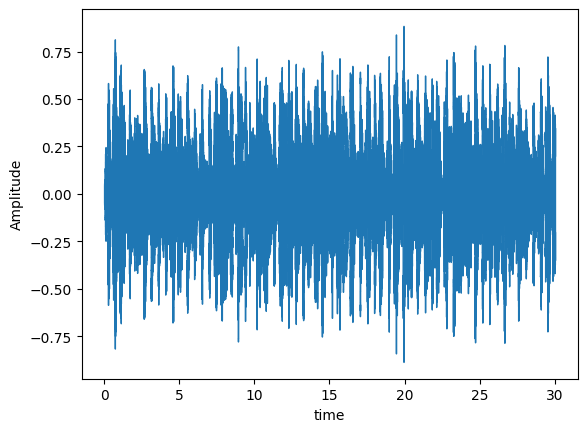

In [4]:
import librosa , librosa.display
import matplotlib.pyplot as plt

# file = r"E:\sound_of_AI\blues.00000.wav"
file = "/content/drive/MyDrive/Data/genres_original/blues/blues.00000.wav"

## waveform
## signal : numpy array -1 D , contians the values, which numbers are equal to T * sr
## each value represnt the amplitude of signal
signal, sr = librosa.load(file, sr=22050)
librosa.display.waveshow(signal, sr=sr)

plt.xlabel("time")
plt.ylabel("Amplitude")
plt.show()


' in power spectrum wwe can see the most of enery is concentrated on the lower frequency\n    higher frquency have to contribution\n    the plot is symmetical - properties of FT - because of Nyquist Criteria\n    only the first half is enough to analyze the data \n '

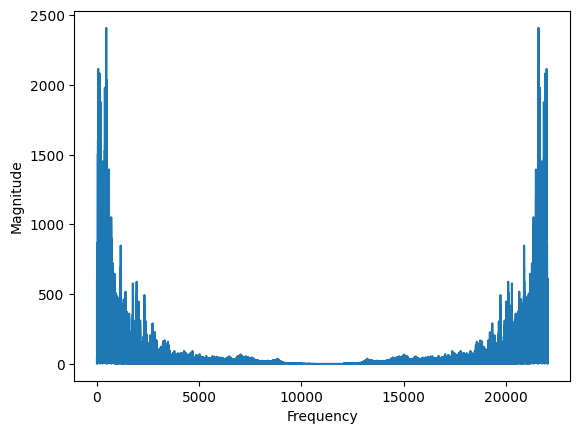

In [ ]:
## fft ---> spectrum
''' 1D array which has number of values equal in original siganl - the values are complex'''

import numpy as np
fft = np.fft.fft(signal)

## calculate the magnitudes of values - gives the frquency contribution in sound
magnitude = np.abs(fft)

frequency = np.linspace(0,sr, len(magnitude))

plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show

''' in power spectrum wwe can see the most of enery is concentrated on the lower frequency
    higher frquency have to contribution
    the plot is symmetical - properties of FT - because of Nyquist Criteria
    only the first half is enough to analyze the data
 '''

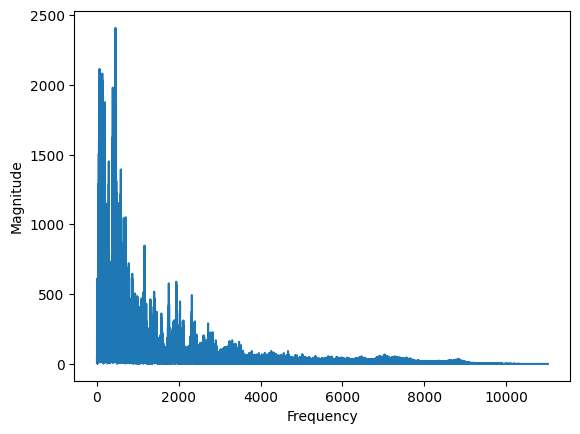

In [ ]:
import numpy as np
fft = np.fft.fft(signal)

## calculate the magnitudes of values - gives the frquency contribution in sound
magnitude = np.abs(fft)

frequency = np.linspace(0,sr, len(magnitude))

## taking only left part - only relevent one
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]

plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

'''it is a static snapshot of the whole sound
   consider averiging of energy of the different frequecncy bins throughout the whole sound
   no time axis
 '''

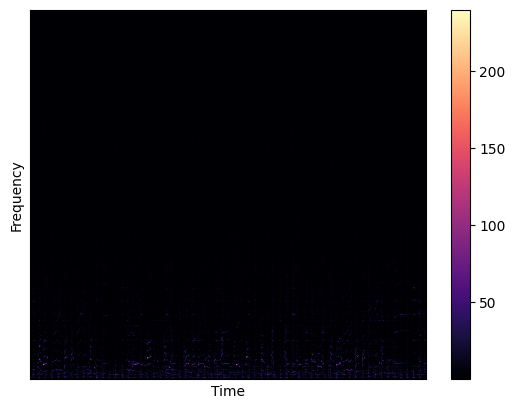

In [ ]:
## STFT ---> spectrogram
### frequncy contribution as well as time info

n_fft = 2048  ##number of samples - window we are considering when we r performing STFT - so each window have 2048 samples/values
hop_length = 512  ## how much we r shifting woindow - by how many samples to right

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

''' complex stft value is converted to magnitude vale - stored in spectrogram variable
    we well have x,y axis + color values - representing the power
    spectrogram- amplitude is function of time and frequency
    amplitude is expressed by color

    most of freuency have very low anplitude/energy - so most is black
    little at bottom - at low frequency - we have small brusts of energies

'''


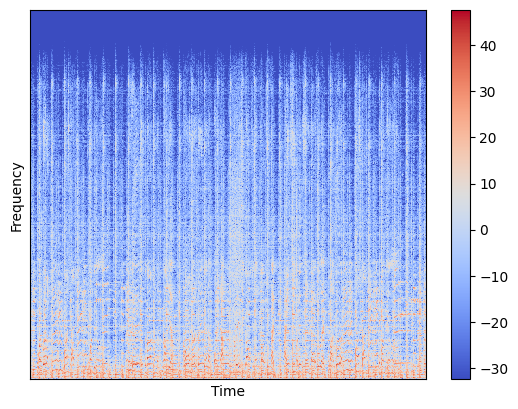

In [ ]:
'''
there is way of smoothing these amplitudes
visualize them in a way as human perceive loudness
not as linear amolitudes in above spectrogram
-it is logarithmic  so we will calculate log spectrum
'''


n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

## taking log - for log spectrogram
## taking amplitufe from our spectrogram and converting them to decibel - i.e making them logarithmic
log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()


'''
blue - very quite sound - : -30 Db
redissh - loud : 40 Db
most of energy is concentrated is low frequency
waveform - was quite stable
and also we can see spectrogram is also quite stabe in low frequency
'''


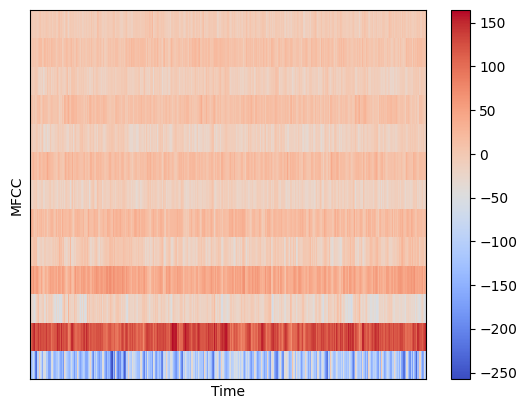

In [ ]:
## MFCCs
## n_mfcc : number of MFCCs coeffficient we want to extract
## to perform MFCCs - we do STFT first so there is hop_lenght and window_lenght

MFCCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

'''
y-axis we have intervals - coefficients - if u count there are 13 segments
x-axis - time - how different MFCCs are evolving aroud time

'''

# Pre_processing music data for Gener classification


*   preparing music data
*   extract inputs and targets - store it in JSON file



In [5]:
import os
import librosa
import math
import json

DATASET_PATH = "/content/drive/MyDrive/Data/genres_original"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050
DURATION = 30  ## measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

## chop the music data into numbers of segment to increase number of inputs
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):

  ## dictionary to store data
  data = {
      "mapping" :[],              ## lsit of gerne
      "mfcc" :[],                 ## mfccs values of data
      "labels" :[]                ## corresponding labels of mfccs
  }

  num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)  ## it may be flot, we will rounf off to higher int : 1.2 --> 2

  ## loop through all the geners
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

    ## ensure that we are not at the root level
    if dirpath is not dataset_path:

      #save the semantic label i.e label in "mapping"
      dirpath_components = dirpath.split("/")    ## gerner/blues ----> ['genre', 'blues']
      semantic_label = dirpath_components[-1]
      data["mapping"].append(semantic_label)
      print("\n Processing {}".format(semantic_label))

      ## process files for specific genre
      counter = 0
      for f in filenames:
        if counter == 10:
          break
        counter = counter + 1
        ## load audio file
        file_path = os.path.join(dirpath, f)
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        ## process segments extracting mfcc and storing data
        for s in range(num_segments):
          start_sample = num_samples_per_segment * s      ## for s = 0 ====> 0
          finish_sample = start_sample + num_samples_per_segment   ### for s = 0 ====> num_samples_per_segments


          mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                               sr=SAMPLE_RATE,
                                               n_fft=n_fft,
                                               n_mfcc=n_mfcc,
                                               hop_length=hop_length)
          mfcc = mfcc.T
          ## sometimes the audio data may not have exact number of samples we would expect
          ## so when we do mfcc we may have more or less number of mfcc vectors
          ## traning data must have same shape

          ## store mfcc for segment if it has expected lenght
          if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist())        ## casting numpy array to list- saave as JSON
            data["labels"].append(i-1)
            print("{}, segment:{}".format(file_path, s))



  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)

if __name__ =="__main__":
  save_mfcc(DATASET_PATH, JSON_PATH)


 Processing blues
/content/drive/MyDrive/Data/genres_original/blues/blues.00006.wav, segment:0
/content/drive/MyDrive/Data/genres_original/blues/blues.00006.wav, segment:1
/content/drive/MyDrive/Data/genres_original/blues/blues.00006.wav, segment:2
/content/drive/MyDrive/Data/genres_original/blues/blues.00006.wav, segment:3
/content/drive/MyDrive/Data/genres_original/blues/blues.00006.wav, segment:4
/content/drive/MyDrive/Data/genres_original/blues/blues.00006.wav, segment:5
/content/drive/MyDrive/Data/genres_original/blues/blues.00006.wav, segment:6
/content/drive/MyDrive/Data/genres_original/blues/blues.00006.wav, segment:7
/content/drive/MyDrive/Data/genres_original/blues/blues.00006.wav, segment:8
/content/drive/MyDrive/Data/genres_original/blues/blues.00006.wav, segment:9
/content/drive/MyDrive/Data/genres_original/blues/blues.00005.wav, segment:0
/content/drive/MyDrive/Data/genres_original/blues/blues.00005.wav, segment:1
/content/drive/MyDrive/Data/genres_original/blues/blues.0

In [ ]:
### Dataset link : https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification